In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Print size of whole training dataset
size_of_training_data = len(training_data)

# SPLITTING DATA INTO 'TRAIN-' AND 'VAL-' sets.

# Init your PyTorch Dataset object
original_data = training_data
size_of_original_data = len(training_data)

# Specify split fractions: !Must sum to 1!
train_fraction = 0.70
val_fraction = 0.30


# Determine size of each set
train_dataset_size = int(train_fraction * size_of_original_data)
val_dataset_size = int(val_fraction * size_of_original_data)

# Split whole original data into train, val and test datsets
train_dataset, val_dataset = torch.utils.data.random_split(
    original_data,
    [train_dataset_size, val_dataset_size])

In [4]:
# Sanity checking
print(f" Train set Size: {len(train_dataset)}")
print(f" Val set Size: {len(val_dataset)}")

 Train set Size: 42000
 Val set Size: 18000


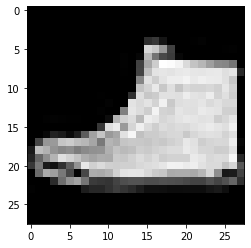

In [5]:
plt.imshow(train_dataset[0][0][0], cmap="gray")

In [6]:
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 100, shuffle = True)
val_dataloader = DataLoader(dataset = train_dataset, batch_size = 100, shuffle = True)

In [7]:
from sklearn.metrics import accuracy_score

def evaluate_model_performance(dataset, model):
# Function that takes in a model and a dataset
# and outputs an performance estimate of the classification
# accuracy of the model.

# Make a Dataloader for the dataset.
# Note, we are not performing any SGD here, so our batch
# size is the whole # dataset we want to evaluate model performance on.
    d_loader = DataLoader(dataset = dataset, batch_size = len(dataset))

    cost_function = nn.CrossEntropyLoss() # For classification evaluation
    model.eval()
    # Make predictions for the eval dataset
    with torch.no_grad():
        for X, y in d_loader:
            raw_y_preds = model(X)

        y_class_preds = raw_y_preds.argmax(dim = 1)
        eval_cost = cost_function(raw_y_preds, y).item()
    model.train()

    # compare predictions with true labels and compute performance metric
    # performance metric in this example is classification accuracy
    eval_acc = accuracy_score(y_pred = y_class_preds, y_true = y)

    return eval_cost, eval_acc

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
    self.fc1 = nn.Linear(in_features=12*4*4,out_features=120)
    self.fc2 = nn.Linear(in_features=120,out_features=60)
    self.fc3 = nn.Linear(in_features=60,out_features=40)
    self.out = nn.Linear(in_features=40,out_features=10)
  def forward(self,x):
    #input layer
    x = x
    #first hidden layer
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x,kernel_size=2,stride=2)
    #second hidden layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x,kernel_size=2,stride=2)
    #third hidden layer
    x = x.reshape(-1,12*4*4)
    x = self.fc1(x)
    x = F.relu(x)
    #fourth hidden layer
    x = self.fc2(x)
    x = F.relu(x)
    #fifth hidden layer
    x = self.fc3(x)
    x = F.relu(x)
    #output layer
    x = self.out(x)
    return x

In [10]:
#defining few parameters
model = Network()
lr = 0.05 #learning_rate
optim = torch.optim.SGD(model.parameters(),lr)
cost_function = nn.CrossEntropyLoss()
epochs = 20

In [11]:
# Trace the cost in mini-batch
training_minibatch_Js =[]

# Traceback the cross entropy cost in the train set and the validation set
cross_entropy_cost_train = []
cross_entropy_cost_val = []

# Traceback the accuracy in the train set and the validation set
accuracy_train = []
accuracy_val = []


for epoch_i in range(epochs):
    eval_every_kth = 1
    if epoch_i % eval_every_kth == 0: # Eval model very k'th epoch.
        model.eval() # set model into evaluate mode #
        # EVALUATE Model 'performance' on whole train and validation dataset
        train_cost, train_acc = evaluate_model_performance(model = model, dataset = train_dataset)
        val_cost, val_acc = evaluate_model_performance(model = model, dataset = val_dataset)
        model.train() # reset model into train mode.

        # track performance measures from both train and val sets
        print("Epoch: {} - Train cost: {}, Train Acc: {}".format(epoch_i, train_cost, train_acc))
        print("Epoch: {} - Val cost: {}, Val Acc: {}".format(epoch_i, val_cost, val_acc))

        cross_entropy_cost_train.append(train_cost)
        cross_entropy_cost_val.append(val_cost)

        accuracy_train.append(train_acc)
        accuracy_val.append(val_acc)

        # Optional stopping criteria based on validation and/or
        # train set performance/cost to avoid overfitting.

    for X_batch, y_batch in train_dataloader:
        y_preds = model(X_batch) # Make predection on batch
        cost = cost_function(y_preds, y_batch) # Compute cost
        training_minibatch_Js.append(cost)
        optim.zero_grad() # zero the grads of all model params
        cost.backward() # compute J gradient of all model params
        optim.step() # take one update step for all model params

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 - Train cost: 2.305094003677368, Train Acc: 0.1005
Epoch: 0 - Val cost: 2.305123805999756, Val Acc: 0.09883333333333333
Epoch: 1 - Train cost: 2.2959678173065186, Train Acc: 0.31135714285714283
Epoch: 1 - Val cost: 2.296095132827759, Val Acc: 0.3056111111111111
Epoch: 2 - Train cost: 0.8793978095054626, Train Acc: 0.6822380952380952
Epoch: 2 - Val cost: 0.8759466409683228, Val Acc: 0.6818888888888889
Epoch: 3 - Train cost: 0.6386003494262695, Train Acc: 0.7603333333333333
Epoch: 3 - Val cost: 0.6359364986419678, Val Acc: 0.7614444444444445
Epoch: 4 - Train cost: 0.5648972392082214, Train Acc: 0.7959285714285714
Epoch: 4 - Val cost: 0.5703379511833191, Val Acc: 0.7933888888888889
Epoch: 5 - Train cost: 0.505255401134491, Train Acc: 0.8116904761904762
Epoch: 5 - Val cost: 0.5123511552810669, Val Acc: 0.8098333333333333
Epoch: 6 - Train cost: 0.5428497195243835, Train Acc: 0.7810952380952381
Epoch: 6 - Val cost: 0.553791344165802, Val Acc: 0.7776111111111111
Epoch: 7 - Train cost

In [13]:
print(cross_entropy_cost_train[-1])
print(accuracy_train[-1])

0.3037092685699463
0.886547619047619


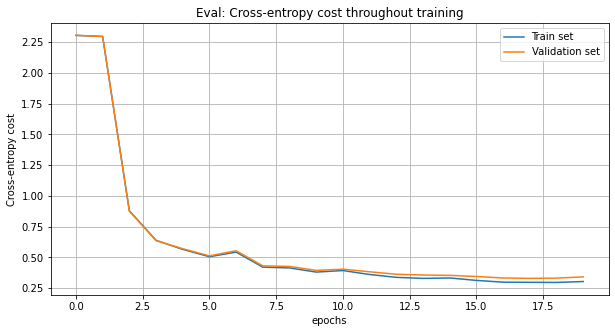

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = [10, 5])
plt.plot(cross_entropy_cost_train, label = 'Train set')
plt.plot(cross_entropy_cost_val, label = 'Validation set')
plt.xlabel('epochs')
plt.ylabel('Cross-entropy cost')
plt.title('Eval: Cross-entropy cost throughout training')
plt.legend()
plt.grid()

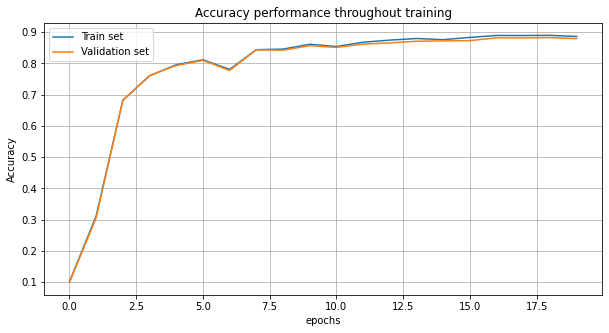

In [16]:
plt.figure(figsize = [10, 5])
plt.plot(accuracy_train, label = 'Train set')
plt.plot(accuracy_val, label = 'Validation set')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy performance throughout training')
plt.legend()
plt.grid()

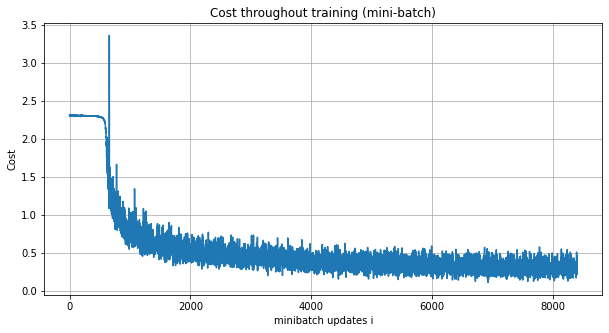

In [17]:
# Plot the cost
plt.figure(figsize = [10, 5])
plt.plot(training_minibatch_Js)
plt.xlabel('minibatch updates i')
plt.ylabel('Cost')
plt.title('Cost throughout training (mini-batch)')
plt.grid()

In [18]:
len(test_data)

test_dataloader = DataLoader(dataset = test_data, batch_size = len(test_data))

with torch.no_grad():
    for X, y in test_dataloader:
        raw_y_preds = model(X) # predict model output for X in test dataset

    y_class_preds = raw_y_preds.argmax(dim = 1)
    cost = cost_function(raw_y_preds, y).item()

acc = accuracy_score(y_pred = y_class_preds, y_true = y)

In [19]:
print("The cost in the test dataset is {: .3}.".format(cost))

The cost in the test dataset is  0.363.


In [20]:
print("The accuracy in the test dataset is {}.".format(acc))

The accuracy in the test dataset is 0.8669.
